# Import

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.signal import firwin, butter, buttord, cheby1, cheb1ord, cheby2, cheb2ord, ellip, ellipord, lfilter, freqz, resample, tf2zpk
import soundfile as sf
import pandas as pd
from scipy.io import wavfile

# ANSI S1.11 STANDARD

## Paramètres globaux

In [2]:
fs = 12000 # fréquence d'échantillonnage
bands = np.arange(22, 37)   # bande 22 → 36 (car fu < fs/2)
Nbands = len(bands) # nombre de bandes
iir_order = 4  # ordre des filtres IIR
iir_type = 'elliptic'  # type de filtre IIR : 'butterworth', 'chebyshev1', 'chebyshev2', 'elliptic'

## Calcul des fréquences ANSI 1/3 octave

In [3]:
def ansi_band(n):
    f0 = 1000 * 2 ** ((n - 30) / 3)
    fl = f0 / 2 ** (1/6)
    fu = f0 * 2 ** (1/6)
    return fl, f0, fu

# stockage des filtres
filters_FIR = []
filters_IIR = []

## Design des filtres FIR et IIR

In [4]:
for n in bands:
    # Pour chaque bande ANSI, on calcule les fréquences de coupure et on normalise (scipy)
    fl, f0, fu = ansi_band(n)
    
    fl_norm = fl / (fs / 2)
    fu_norm = fu / (fs / 2)

    # FIR 1/3 octave (bandpass)
    taps = firwin(                 # design FIR windowed (méthode de Hamming)
        numtaps=128,               # (ordre 127)
        cutoff=[fl, fu],           # bande passante en Hz
        pass_zero=False,
        fs=fs
    )
    filters_FIR.append(taps)

    # IIR selon le type choisi
    if iir_type == 'butterworth':
        b, a = butter(N=iir_order, Wn=[fl_norm, fu_norm], btype='bandpass', output='ba')
    elif iir_type == 'chebyshev1':
        b, a = cheby1(N=iir_order, rp=1, Wn=[fl_norm, fu_norm], btype='bandpass', output='ba')
    elif iir_type == 'chebyshev2':
        b, a = cheby2(N=iir_order, rs=60, Wn=[fl_norm, fu_norm], btype='bandpass', output='ba')
    elif iir_type == 'elliptic':
        b, a = ellip(N=iir_order, rp=1, rs=60, Wn=[fl_norm, fu_norm], btype='bandpass', output='ba')
    else:
        raise ValueError(f"Type IIR inconnu : {iir_type}")
    
    filters_IIR.append((b, a))

print("Les 16 filtres 1/3-octave ont été générés avec succès !")

Les 16 filtres 1/3-octave ont été générés avec succès !


Juste pour rappelle :')
Un SOS d'ordre 2 (ce que l'on a) est de la forme :

$$H_i(z) = 
\frac{
b_{0,i} + b_{1,i} z^{-1} + b_{2,i} z^{-2}
}{
1 + a_{1,i} z^{-1} + a_{2,i} z^{-2}
}
$$

## Plot des réponses fréquentielles (FIR)

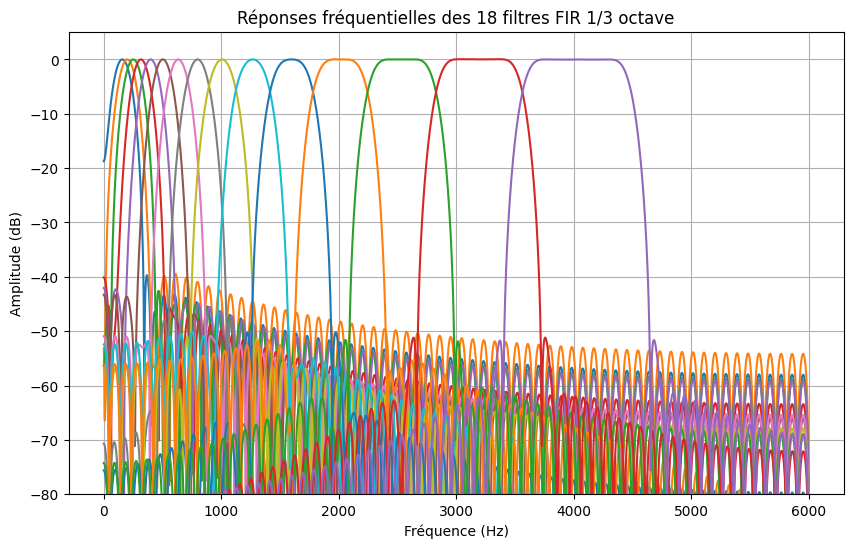

In [5]:
plt.figure(figsize=(10,6))
for taps in filters_FIR:
    # Calcul de la réponse fréquentielle complexe H(e^{jw})
    # w : vecteur de fréquences (en Hz, grâce à fs=fs)
    # h : réponse fréquentielle complexe
    w, h = freqz(taps, [1], worN=2048, fs=fs)
    plt.plot(w, 20*np.log10(np.abs(h)))


plt.title("Réponses fréquentielles des 18 filtres FIR 1/3 octave")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-80, 5])
plt.show()

## Plot des réponses fréquentielles (IIR)

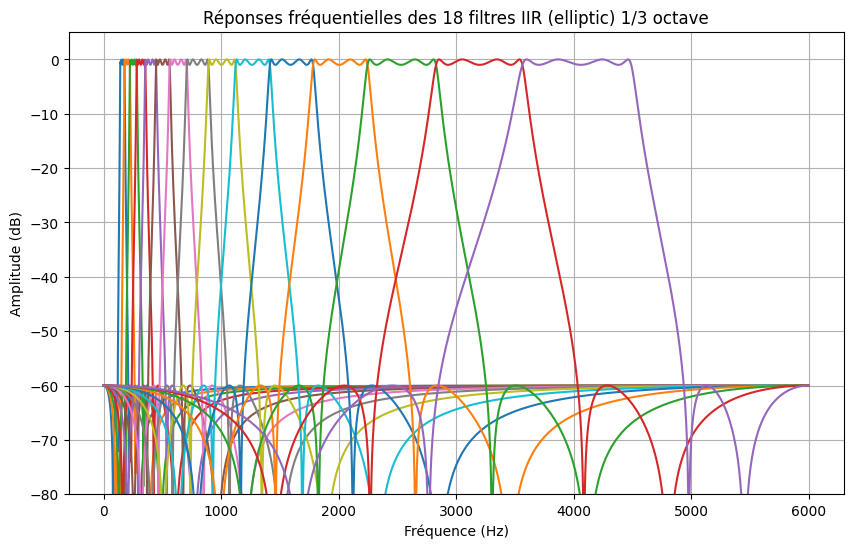

In [6]:
plt.figure(figsize=(10,6))
for b, a in filters_IIR:
    # Calcul de la réponse fréquentielle complexe H(e^{jw})
    # w : vecteur de fréquences (en Hz, grâce à fs=fs)
    # h : réponse fréquentielle complexe
    w, h = freqz(b, a, worN=2048, fs=fs)
    plt.plot(w, 20*np.log10(np.abs(h)))


plt.title(f"Réponses fréquentielles des 18 filtres IIR ({iir_type}) 1/3 octave")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-80, 5])
plt.show()

## Test sur audio

In [7]:
signal, fs_in = sf.read("test.wav")

# Convertir en mono si stéréo
if signal.ndim > 1:
    signal = np.mean(signal, axis=1)

# Resample si besoin
if fs_in != fs:
    signal = resample(signal, int(len(signal) * fs / fs_in))
    print(f"Audio resamplé de {fs_in} Hz à {fs} Hz")

filtered_bands = []

#for taps in filters_FIR:
#    filtered_sig = np.convolve(signal, taps, mode='same')

for b, a in filters_IIR:
    filtered_sig = lfilter(b, a, signal)
    filtered_bands.append(filtered_sig)

filtered_bands = np.array(filtered_bands).T

print("Filtrage terminé !")

Audio resamplé de 48000 Hz à 12000 Hz
Filtrage terminé !


## Sauvegarde des bandes filtrées

In [8]:
# Sauvegarde des bandes filtrées
import os
if not os.path.exists('filtered_bands'):
    os.makedirs('filtered_bands')

for i, band in enumerate(bands):
    filename = f"filtered_bands/band_{band}.wav"
    sf.write(filename, filtered_bands[:, i], fs)
    print(f"Bande {band} sauvegardée dans {filename}")

print("Toutes les bandes filtrées ont été sauvegardées !")

Bande 22 sauvegardée dans filtered_bands/band_22.wav
Bande 23 sauvegardée dans filtered_bands/band_23.wav
Bande 24 sauvegardée dans filtered_bands/band_24.wav
Bande 25 sauvegardée dans filtered_bands/band_25.wav
Bande 26 sauvegardée dans filtered_bands/band_26.wav
Bande 27 sauvegardée dans filtered_bands/band_27.wav
Bande 28 sauvegardée dans filtered_bands/band_28.wav
Bande 29 sauvegardée dans filtered_bands/band_29.wav
Bande 30 sauvegardée dans filtered_bands/band_30.wav
Bande 31 sauvegardée dans filtered_bands/band_31.wav
Bande 32 sauvegardée dans filtered_bands/band_32.wav
Bande 33 sauvegardée dans filtered_bands/band_33.wav
Bande 34 sauvegardée dans filtered_bands/band_34.wav
Bande 35 sauvegardée dans filtered_bands/band_35.wav
Bande 36 sauvegardée dans filtered_bands/band_36.wav
Toutes les bandes filtrées ont été sauvegardées !
Bande 29 sauvegardée dans filtered_bands/band_29.wav
Bande 30 sauvegardée dans filtered_bands/band_30.wav
Bande 31 sauvegardée dans filtered_bands/band_31.

## Plot de comparaison FIR vs IIR

In [9]:
def add_ansi_overlay(ax, fl, fu, fs):
    """
    Ajoute des superpositions graphiques pour les spécifications ANSI S1.11 sur un axe matplotlib.
    
    Args:
        ax: objet matplotlib.axes.Axes sur lequel ajouter les overlays
        fl: fréquence basse de la bande passante (Hz)
        fu: fréquence haute de la bande passante (Hz)
        fs: fréquence d'échantillonnage (Hz)
    """
    
    # Spécifications ANSI S1.11 classe 2
    ripple_max = 1.0  # ripple max dans la bande passante (dB)
    atten_min = 60.0  # atténuation min dans les bandes d'arrêt (dB)
    
    # Calcul des limites des bandes d'arrêt
    stop_lo_end = fl / (2 ** (1/6))  # fin de la bande d'arrêt basse
    stop_hi_start = fu * (2 ** (1/6))  # début de la bande d'arrêt haute
    
    # Lignes verticales pour les limites de fréquence
    ax.axvline(fl, color='green', linestyle='--', alpha=0.7, label='Début bande passante')
    ax.axvline(fu, color='green', linestyle='--', alpha=0.7, label='Fin bande passante')
    ax.axvline(stop_lo_end, color='red', linestyle='--', alpha=0.7, label='Fin arrêt bas')
    ax.axvline(stop_hi_start, color='red', linestyle='--', alpha=0.7, label='Début arrêt haut')
    
    # Ligne horizontale pour l'atténuation minimale
    ax.axhline(-atten_min, color='red', linestyle='--', alpha=0.7, label='Atténuation min (-60 dB)')
    
    # Zone de ripple dans la bande passante (±1 dB autour de 0 dB)
    ax.fill_between([fl, fu], -ripple_max, ripple_max, color='blue', alpha=0.1, label='Zone ripple (±1 dB)')

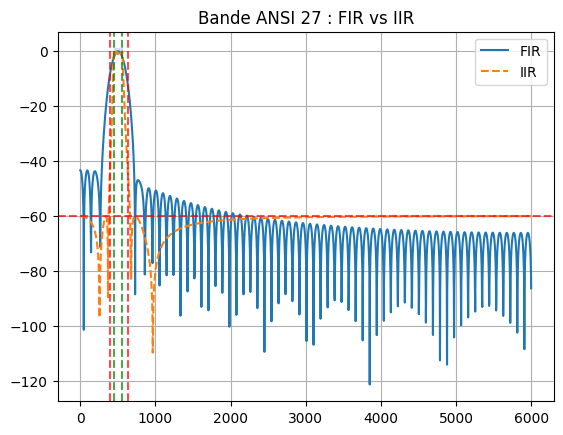

In [10]:
k = 5  # bande 27
fl, f0, fu = ansi_band(bands[k])
taps = filters_FIR[k]
b, a = filters_IIR[k]

# FIR
w, h = freqz(taps, [1], worN=2048, fs=fs)
plt.plot(w, 20*np.log10(np.abs(h)), label="FIR")

# IIR
w2, h2 = freqz(b, a, worN=2048, fs=fs)
plt.plot(w2, 20*np.log10(np.abs(h2)), '--', label="IIR")

plt.legend()
plt.grid(True)
plt.title(f"Bande ANSI {bands[k]} : FIR vs IIR")
add_ansi_overlay(plt.gca(), fl, fu, fs)
plt.show()

In [11]:
def quantize(coeffs, word_length, integer_bits=1, wrap=False):
    """
    Quantifie des coefficients en format virgule fixe Qm.n.
    
    Qm.n = m bits partie entière (avec signe) + n bits fractionnaire.
    Ici : Q(integer_bits).(word_length - integer_bits)
    
    Exemples:
    - quantize(coeffs, 8, 1)  -> Q1.7
    - quantize(coeffs, 16, 3) -> Q3.13
    
    Args:
        coeffs: array des coefficients (float)
        word_length: bits total (inclut bit de signe)
        integer_bits: bits partie entière (1 pour FIR, 3+ pour IIR)
        wrap : False = saturation, True = wrap-around complément a 2
    
    Returns:
        array: coefficients quantifiés (float arrondis)
    """
    
    if word_length <= integer_bits:
        raise ValueError("word_length doit être > integer_bits (inclut bit de signe).")

    # Nombre de bits fractionnaires
    frac_bits = word_length - integer_bits
    
    # Facteur d'échelle pour la partie fractionnaire
    scale = 2**frac_bits
    
    # Passage en entier fixe
    fixed = np.round(coeffs * scale)
    
    # Bornes min/max representables
    MIN = -(2 ** (integer_bits - 1))
    MAX = (2 ** (integer_bits - 1)) - (1 / scale) # ICI - (1 / scale) car c'est la plus petite valeur representable en Qm.n

    
    if wrap:
        # Wrap-around (complement a 2)
        # On ne pense pas que ce soit utile ici, saturation est préférable selon nous
        # En gros quand une valeur dépasse MAX, elle "reboucle" vers MIN et inversement
        
        # Plage totale pour un entier non signé
        range_int = 2 ** word_length
        
        # No joke regardez cette qualité de ligne, on va détailler un peu ;')
        # range_int//2 = 2^(word_length-1) : donc point milieu 
        # fixed.astype(int) convertit en entier pour l'opération modulo
        # Ici modulo est utilisé pour "reboucler" les valeurs hors bornes
        # - (range_int//2) pour soustraire le décalage initial
        fixed = ((fixed.astype(int) + range_int//2) % range_int) - (range_int//2)
    else:
        # Saturation
        # Les valeurs qui dépassent sont "écrasées" aux bornes, donc en théorie moins d'instabilités
        fixed = np.clip(fixed, MIN * scale, MAX * scale)

    return fixed / scale


integer_bits nécessaire pour IIR = 7
WL = 7 bits ignoré (wl <= integer_bits_iir).
WL = 7 bits ignoré (wl <= integer_bits_iir).


/tmp/ipykernel_136962/1693662067.py:39: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label='IIR quantifié')
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:482: RuntimeWarning: divide by zero encountered in divide
  h = (npp_polyval(zm1, b, tensor=False) /
/home/maxime/.local/lib/python3.10/site-packages/scipy/signal/_filter_design.py:482: RuntimeWarning: invalid value encountered in divide
  h = (npp_polyval(zm1, b, tensor=False) /
/tmp/ipykernel_136962/1693662067.py:38: RuntimeWarning: divide by zero encountered in log10
  plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label='FIR quantifié')


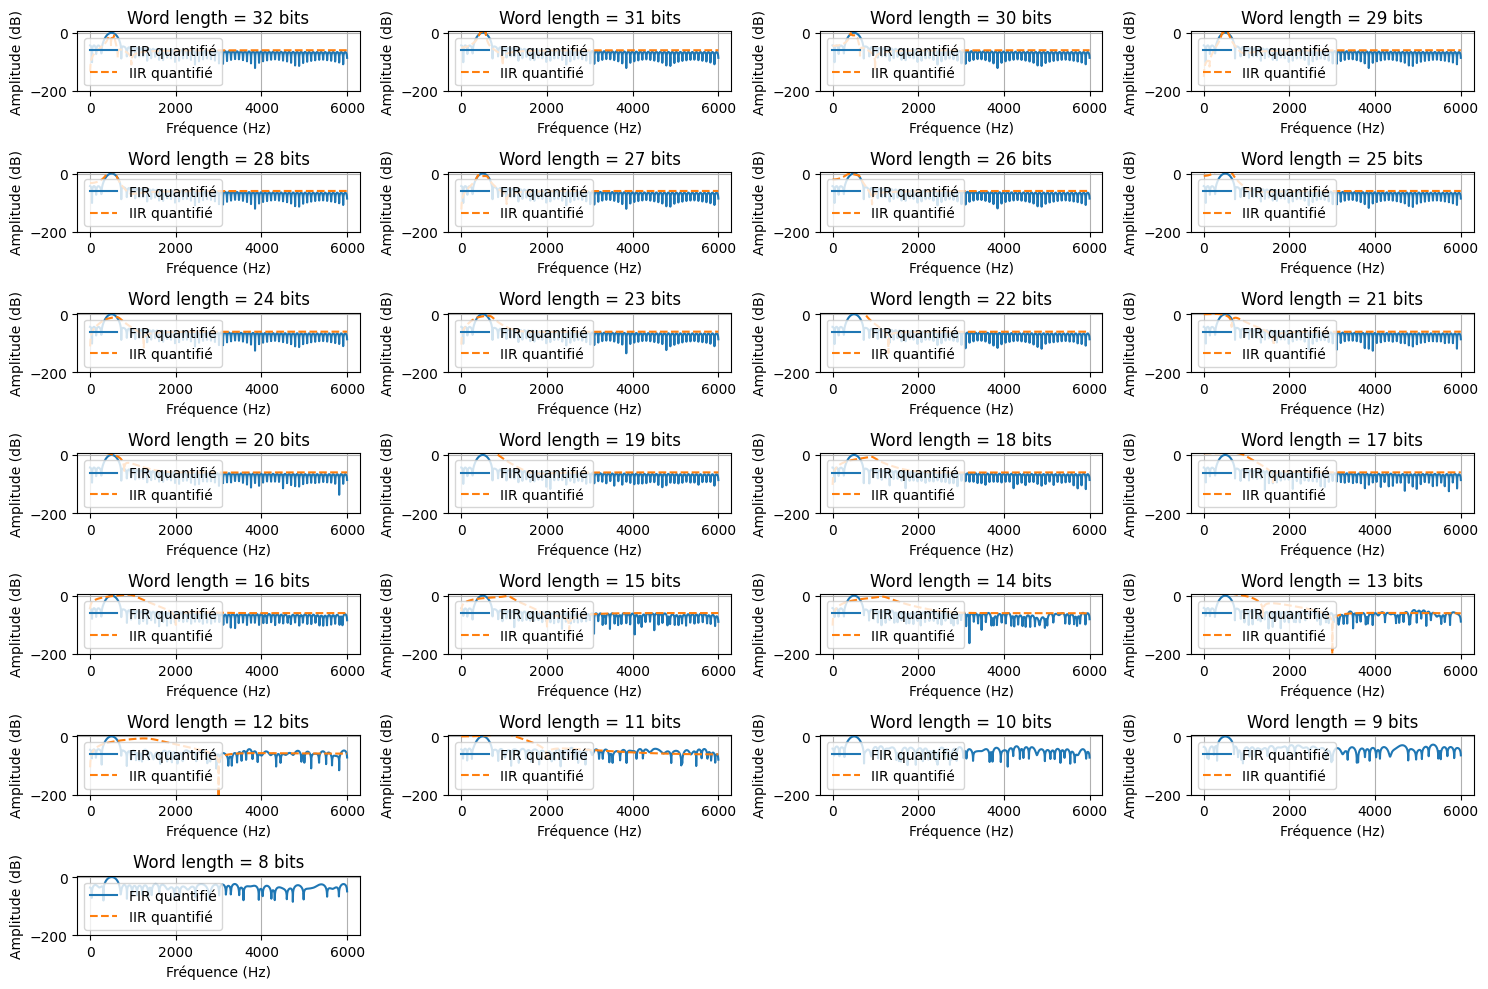

In [12]:
word_lengths = list(range(32, 6, -1))  # 32 à 7 bits

k = 5  # bande 27
taps_original = filters_FIR[k]
b_original, a_original = filters_IIR[k]

# Calcul dynamique pour nombre de bits entiers des coefficients IIR
max_iir_coeff = max(
    np.max(np.abs(b_original)),
    np.max(np.abs(a_original))
)
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits nécessaire pour IIR = {integer_bits_iir}")

plt.figure(figsize=(15, 10))

for i, wl in enumerate(word_lengths):

    # Si wl n'a pas assez de bits → on saute
    if wl <= integer_bits_iir:
        print(f"WL = {wl} bits ignoré (wl <= integer_bits_iir).")
        continue

    # FIR quantifié
    taps_q = quantize(taps_original, wl, integer_bits=1)

    # IIR quantifié
    b_q = quantize(b_original, wl, integer_bits=integer_bits_iir)
    a_q = quantize(a_original, wl, integer_bits=integer_bits_iir)
    a_q[0] = 1.0  # normalisation

    # Réponses fréquentielles
    w_fir, h_fir = freqz(taps_q, [1], worN=2048, fs=fs)
    w_iir, h_iir = freqz(b_q, a_q, worN=2048, fs=fs)

    # Plot
    plt.subplot(len(word_lengths)//4 + 1, 4, i+1)
    plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label='FIR quantifié')
    plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label='IIR quantifié')
    plt.title(f'Word length = {wl} bits')
    plt.xlabel('Fréquence (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.grid(True)
    plt.ylim([-200, 5])
    plt.legend()

plt.tight_layout()
plt.show()

Max coeff IIR = 62.8065866253798
integer_bits IIR = 7


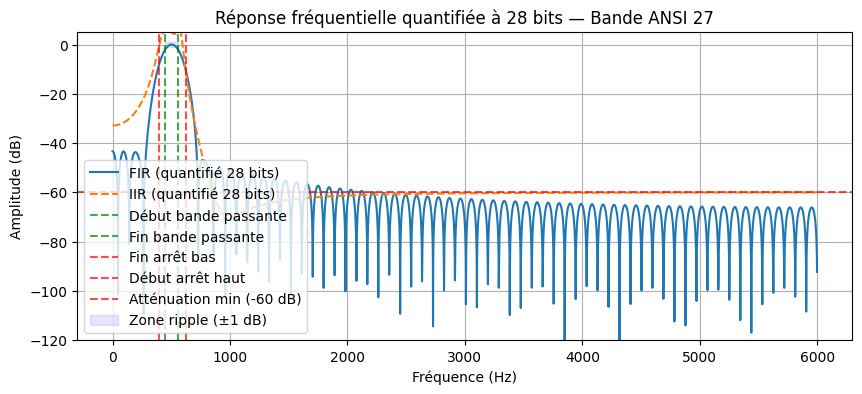

In [13]:
# Choix de la bande
k = 5   # bande ANSI 27 = centre environ 1000 Hz

# Coefficients originaux
taps_original = filters_FIR[k]
b_original, a_original = filters_IIR[k]

# Calcul dynamique pour nombre de bits entiers des coefficients IIR
max_iir_coeff = max(
    np.max(np.abs(b_original)),
    np.max(np.abs(a_original))
)
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print("Max coeff IIR =", max_iir_coeff)
print("integer_bits IIR =", integer_bits_iir)


# Quantification à 28 bits
wl = 28

# FIR quantifié (1 bit entier → Q1.(wl-1))
taps_q = quantize(taps_original, wl, integer_bits=1)

# IIR quantifié :
#  - integer_bits_iir bits pour la partie entière (sûr)
#  - a0 doit rester EXACTEMENT à 1.0
b_q = quantize(b_original, wl, integer_bits=integer_bits_iir)
a_q = quantize(a_original, wl, integer_bits=integer_bits_iir)
a_q[0] = 1.0     # normalisation indispensable

# Réponses fréquentielles
w_fir, h_fir = freqz(taps_q, [1], worN=4096, fs=fs)
w_iir, h_iir = freqz(b_q, a_q, worN=4096, fs=fs)

# AFFICHAGE
plt.figure(figsize=(10, 4))
plt.plot(w_fir, 20*np.log10(np.abs(h_fir)), label=f'FIR (quantifié {wl} bits)')
plt.plot(w_iir, 20*np.log10(np.abs(h_iir)), '--', label=f'IIR (quantifié {wl} bits)')

# Specification ANSI (pour la bande 27)
fl, f0, fu = ansi_band(bands[k])
add_ansi_overlay(plt.gca(), fl, fu, fs)

plt.title(f"Réponse fréquentielle quantifiée à {wl} bits — Bande ANSI {bands[k]}")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-120, 5])
plt.legend()
plt.show()


## Comparaison avant/après quantification

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


integer_bits pour cette bande IIR = 7
IIR Original – Bande 27:
  Zéros: [0.87505989+0.48401466j 0.87505989-0.48401466j 0.93812743+0.34629022j
 0.93812743-0.34629022j 0.99101795+0.13372888j 0.99101795-0.13372888j
 0.98134348+0.1922628j  0.98134348-0.1922628j ]
  Pôles: [0.95315056+0.28796593j 0.95315056-0.28796593j 0.95190579+0.2685438j
 0.95190579-0.2685438j  0.96950166+0.23064008j 0.96950166-0.23064008j
 0.95954957+0.24392585j 0.95954957-0.24392585j]
IIR Quantifié (16 bits) – Bande 27:
  Zéros: [0.42534491+2.34873337j 0.42534491-2.34873337j 0.5       +0.8660254j
 0.5       -0.8660254j  0.99999997+0.j         1.00000003+0.j
 0.07465509+0.4122417j  0.07465509-0.4122417j ]
  Pôles: [1.33108555+0.34952236j 1.33108555-0.34952236j 0.93906685+0.51607821j
 0.93906685-0.51607821j 1.        +0.j         0.72818687+0.34054711j
 0.72818687-0.34054711j 0.67129022+0.j        ]


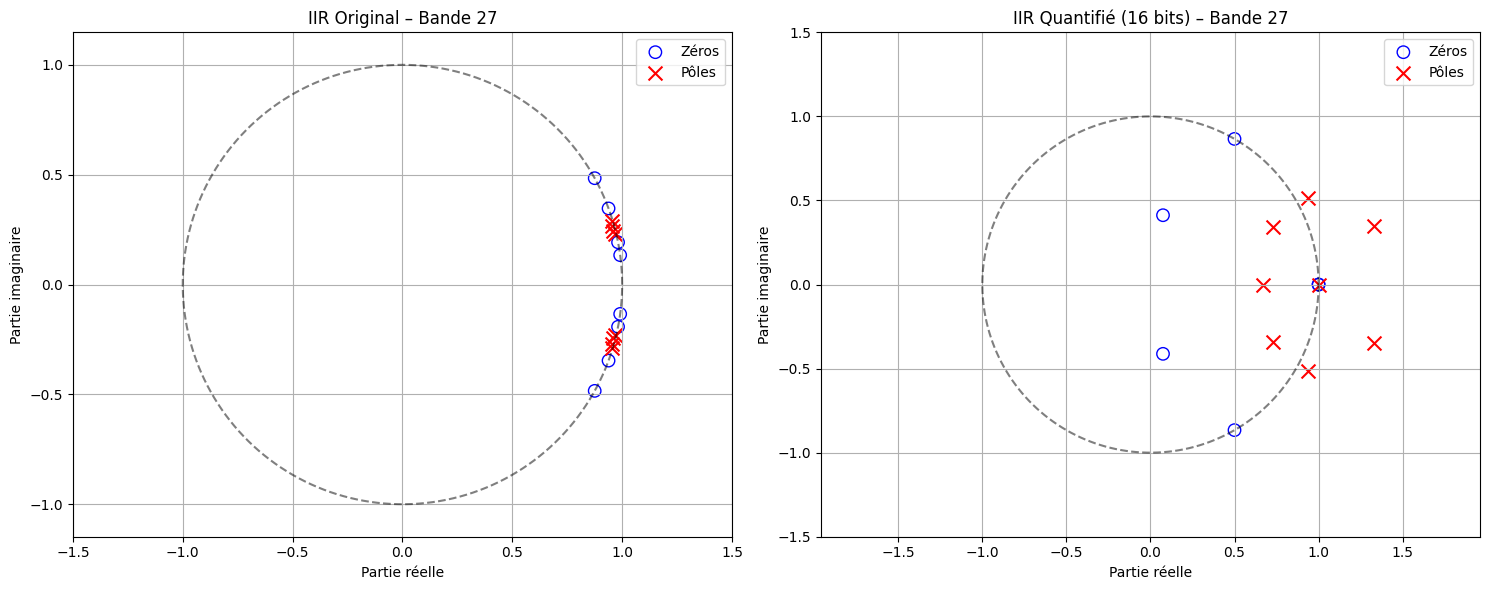

In [14]:
k = 5  # bande 27
b_orig, a_orig = filters_IIR[k]

# Détection automatique des bits entiers IIR
max_iir_coeff = max(
    np.max(np.abs(b_orig)),
    np.max(np.abs(a_orig))
)
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits pour cette bande IIR = {integer_bits_iir}")

# Quantification
wl = 16
if wl <= integer_bits_iir:
    raise ValueError(f"WL={wl} bits < integer_bits nécessaires={integer_bits_iir}")

b_q = quantize(b_orig, wl, integer_bits=integer_bits_iir)
a_q = quantize(a_orig, wl, integer_bits=integer_bits_iir)
a_q[0] = 1.0  # normalisation impérative


# Plot pôles / zéros 
def plot_pz(b, a, title, subplot_pos):
    z, p, k = tf2zpk(b, a)

    print(f"{title}:")
    print("  Zéros:", z)
    print("  Pôles:", p)

    plt.subplot(1, 2, subplot_pos)
    plt.scatter(np.real(z), np.imag(z), marker='o', s=80, facecolors='none', edgecolors='b', label='Zéros')
    plt.scatter(np.real(p), np.imag(p), marker='x', s=100, color='r', label='Pôles')

    # Cercle unité
    theta = np.linspace(0, 2*np.pi, 400)
    plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5)

    plt.axis('equal')
    plt.grid(True)
    plt.title(title)
    plt.xlabel("Partie réelle")
    plt.ylabel("Partie imaginaire")
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.legend()


plt.figure(figsize=(15, 6))
plot_pz(b_orig, a_orig, f'IIR Original – Bande {bands[k]}', 1)
plot_pz(b_q, a_q, f'IIR Quantifié ({wl} bits) – Bande {bands[k]}', 2)

plt.tight_layout()
plt.show()


integer_bits IIR = 7


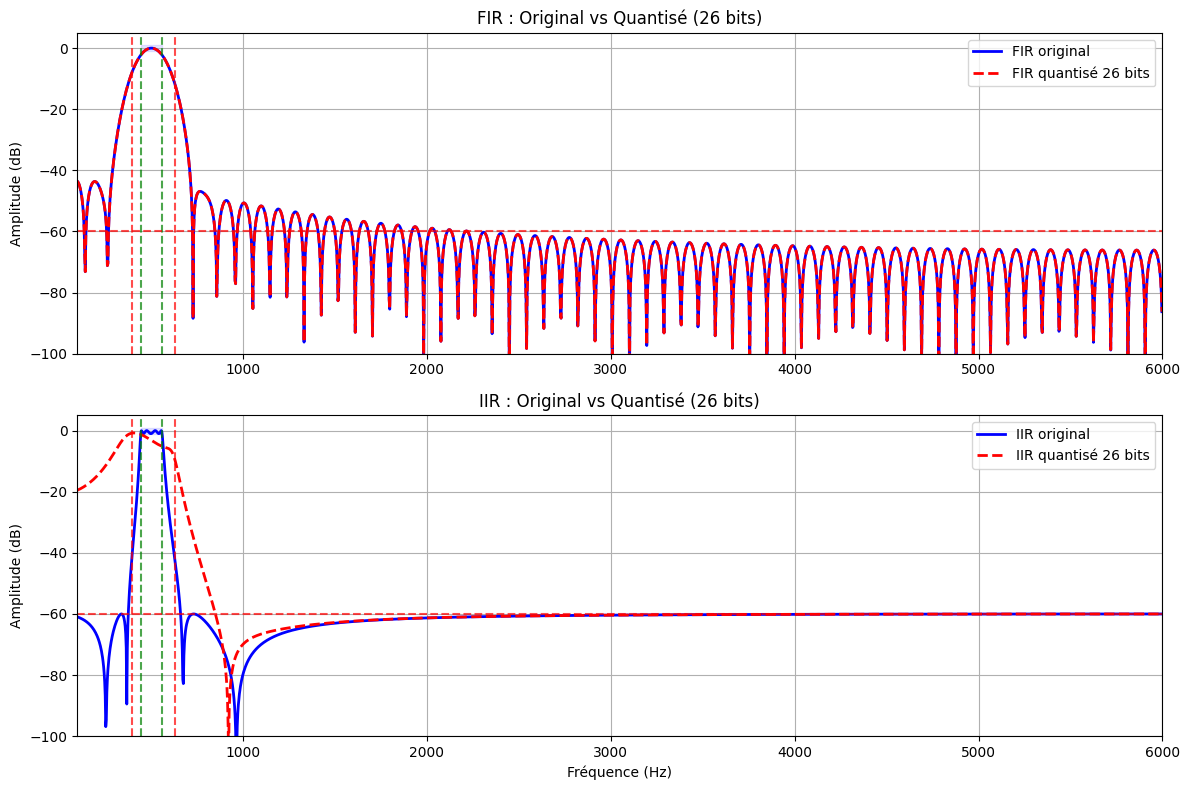

In [15]:
import math

wl = 26
k = 5  # bande 27

taps_orig = filters_FIR[k]
b_orig, a_orig = filters_IIR[k]

# Choix dynamique du nombre de bits entiers pour l’IIR 
max_iir_coeff = max(np.max(np.abs(b_orig)), np.max(np.abs(a_orig)))
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits IIR = {integer_bits_iir}")

if wl <= integer_bits_iir:
    raise ValueError(f"WL={wl} est trop petit pour ces IIR (besoin de {integer_bits_iir} bits entiers).")

# Quantifications
taps_q = quantize(taps_orig, wl, integer_bits=1)

b_q = quantize(b_orig, wl, integer_bits=integer_bits_iir)
a_q = quantize(a_orig, wl, integer_bits=integer_bits_iir)
a_q[0] = 1.0

# Réponses fréquentielles
w_orig_fir, h_orig_fir = freqz(taps_orig, [1], worN=2048, fs=fs)
w_q_fir,   h_q_fir   = freqz(taps_q,       [1], worN=2048, fs=fs)

w_orig_iir, h_orig_iir = freqz(b_orig, a_orig, worN=2048, fs=fs)
w_q_iir,   h_q_iir   = freqz(b_q,   a_q,   worN=2048, fs=fs)

# PLOTS 
plt.figure(figsize=(12, 8))

# FIR
plt.subplot(2, 1, 1)
plt.plot(w_orig_fir, 20*np.log10(np.abs(h_orig_fir)), 'b', linewidth=2, label='FIR original')
plt.plot(w_q_fir,   20*np.log10(np.abs(h_q_fir)),   'r--', linewidth=2, label=f'FIR quantisé {wl} bits')
plt.title(f'FIR : Original vs Quantisé ({wl} bits)')
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-100, 5])
plt.legend()
plt.xlim([100, 6000])

# IIR
plt.subplot(2, 1, 2)
plt.plot(w_orig_iir, 20*np.log10(np.abs(h_orig_iir)), 'b', linewidth=2, label='IIR original')
plt.plot(w_q_iir,   20*np.log10(np.abs(h_q_iir)),   'r--', linewidth=2, label=f'IIR quantisé {wl} bits')
plt.title(f'IIR : Original vs Quantisé ({wl} bits)')
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Amplitude (dB)")
plt.grid(True)
plt.ylim([-100, 5])
plt.legend()
plt.xlim([100, 6000])

# Ajout des overlays ANSI
fl, f0, fu = ansi_band(bands[k])
add_ansi_overlay(plt.subplot(2, 1, 1), fl, fu, fs)
add_ansi_overlay(plt.subplot(2, 1, 2), fl, fu, fs)

plt.tight_layout()
plt.show()

In [16]:
print("\n=== Exemple quantif FIR / IIR pour WL = 24 bits ===")
print("Taps FIR orig :", taps_original[:5])
print("Taps FIR q24   :", quantize(taps_original, 24, integer_bits=1)[:5])

print("\nCoeffs IIR orig :")
print("b:", b_original)
print("a:", a_original)

# Choix dynamique du nombre de bits entiers pour l’IIR 
max_iir_coeff = max(np.max(np.abs(b_orig)), np.max(np.abs(a_orig)))
integer_bits_iir = math.ceil(math.log2(max_iir_coeff)) + 1
print(f"integer_bits IIR = {integer_bits_iir}")

b_q24 = quantize(b_original, 24, integer_bits=integer_bits_iir)
a_q24 = quantize(a_original, 24, integer_bits=integer_bits_iir)
a_q24[0] = 1.0

print("\nCoeffs IIR q24 :")
print("b:", b_q24)
print("a:", a_q24)


=== Exemple quantif FIR / IIR pour WL = 24 bits ===
Taps FIR orig : [-0.0006461  -0.00093321 -0.00118781 -0.00139538 -0.00153802]
Taps FIR q24   : [-0.00064611 -0.00093317 -0.0011878  -0.00139534 -0.00153804]

Coeffs IIR orig :
b: [ 0.00101144 -0.00765768  0.0257702  -0.05034268  0.06243746 -0.05034268
  0.0257702  -0.00765768  0.00101144]
a: [  1.          -7.66821517  25.99320727 -50.85671385  62.80658663
 -50.13110622  25.25678905  -7.34467261   0.94414586]
integer_bits IIR = 7

Coeffs IIR q24 :
b: [ 0.00101471 -0.00765991  0.02577209 -0.05034637  0.06243896 -0.05034637
  0.02577209 -0.00765991  0.00101471]
a: [  1.          -7.66821289  25.99320984 -50.85671234  62.80658722
 -50.13110352  25.25679016  -7.34467316   0.9441452 ]


## Interprétation

ICI, chaque ligne du tableau SOS correspond à une section IIR d'ordre 2.  
Le filtre complet est obtenu en mettant toutes ces sections **en cascade**.

Un SOS est toujours de la forme :

[b0  b1  b2   a0  a1  a2] avec **a0 = 1** (normalisation standard).

Les filtres 1/3-octave ANSI S1.11 sont très étroits : leurs pôles sont
proches du cercle unité, donc une très petite erreur sur a1 ou a2 peut
modifier fortement la réponse ou rendre le filtre instable.

À l'inverse, les FIR n'ont **pas de rétroaction**, sont toujours stables et
supportent beaucoup mieux la quantification fixe.

Les filtres IIR choisis offrent une transition plus abrupte que les FIR
pour le même ordre, au prix de possibles instabilités ou ripples.


## Verification standard + guess ordre du filtre

In [17]:
def verify_ansi_standard(taps, fl, fu, fs, delta_rel=0.05):
    """
    Vérifie si un filtre FIR de bande 1/3-octave respecte le standard
    ANSI S1.11 (classe 2), avec une marge relative
    Args:
    
        taps : array coefficients du filtre FIR
        fl : float fréquence de coupure basse de la bande utile (en Hz)
        fu : float fréquence de coupure haute de la bande utile (en Hz)
        fs : float fréquence d'échantillonnage du système (en Hz)
        delta_rel : float, optionnel marge relative en dB (facteur multiplicatif)

    Returns:
        dict
            {
                "ripple_db"         : ripple dans la bande passante (dB),
                "att_low_db"        : atténuation dans la bande d'arrêt basse (dB),
                "att_high_db"       : atténuation dans la bande d'arrêt haute (dB),
                "valid"             : True si le filtre respecte le standard (avec marge delta),
                "spec_ripple_max"   : limite max du ripple (avec marge),
                "spec_atten_min"    : limite min de l'atténuation (avec marge)
            }
    """
    
    # Spécification AINSI S1.11 classe 2
    ripple_max = 1.0 # + ou - 1 dB
    atten_min  = 60.0 # 60 dB stopband
    
    # On applique la marge relative
    ripple_max *= (1 + delta_rel)
    atten_min  *= (1 - delta_rel)
    

    w, h = freqz(taps, worN=4096, fs=fs)

    # + epsilon pour éviter log(0)
    H = 20 * np.log10(np.abs(h) + 1e-12)

    # Définition des zones de fréquence selon ANSI S1.11:
    # - passband: entre fl et fu
    # - stopband basse: en dessous de fl / 2^(1/6)
    # - stopband haute: au-dessus de fu * 2^(1/6)
    passband = (w >= fl) & (w <= fu)
    stop_lo  = w <  fl / (2 ** (1/6))
    stop_hi  = w >  fu * (2 ** (1/6))

    # En réalité, dans la bande passante le gain du filtre n'est pas parfaitement plat,
    # il y a des variations (ondulations) appelées "ripple"
    # Pour évaluer la performance du filtre, on calcule le ripple comme la
    # différence max-min de l'amplitude en dB dans la passband
    ripple = H[passband].max() - H[passband].min()

    # Atténuation dans les bandes d'arrêt : on prend la valeur la "moins atténuée"
    # (c'est-à-dire la plus proche de 0 dB, donc la pire performance)
    att_lo = -H[stop_lo].max()
    att_hi = -H[stop_hi].max()

    # Vérifications ANSI
    ripple_ok  = ripple <= ripple_max
    stop_lo_ok = att_lo >= atten_min
    stop_hi_ok = att_hi >= atten_min

    return {
        "ripple_db": ripple,
        "att_low_db": att_lo,
        "att_high_db": att_hi,
        "valid": ripple_ok and stop_lo_ok and stop_hi_ok,
        "spec_ripple_max": ripple_max,
        "spec_atten_min": atten_min
    }

In [18]:
def guess_fir_order(fl, fu, fs, delta_rel=0.05, max_order=200000):
    """
    Recherche dichotomique du plus petit ordre FIR qui respecte ANSI S1.11
    
    Note : Scipy n’a pas d’équivalent de 'filterorder' MATLAB pour FIR
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
        max_order : ordre max à tester (évite boucle infinie)
    
    Returns:
        int : ordre minimal FIR, ou None si pas trouvé dans max_order
    """
    
    # Recherche binaire : on teste des ordres de plus en plus petits/grands
    # pour trouver le plus petit ordre qui satisfait les specs ANSI
    low = 1  # ordre min
    high = max_order  # ordre max
    best = None  # meilleur ordre trouvé (initialement None)
    
    while low <= high:
        mid = (low + high) // 2  # ordre milieu à tester
        
        # Crée un filtre FIR d'ordre mid-1 (numtaps = ordre + 1 car normalement numtaps = ordre + 1)
        taps = firwin(
            numtaps=mid,
            cutoff=[fl/(fs/2), fu/(fs/2)],
            pass_zero=False
        )
        
        # Vérifie si ce filtre respecte ANSI avec la marge delta (relative)
        result = verify_ansi_standard(taps, fl, fu, fs, delta_rel)
        
        if result["valid"]:
            # Filtre valide : on peut essayer plus petit (chercher min)
            best = mid
            high = mid - 1
        else:
            # Pas valide : besoin d'ordre plus élevé
            low = mid + 1
    
    return best

In [19]:
def guess_iir_order(fl, fu, fs, delta_rel=0.05, iir_type='chebyshev1'):
    """
    Utilise directement la fonction ord appropriée pour obtenir l'ordre minimal IIR
    
    Args:
        fl, fu, fs : fréquences et échantillonnage (en Hz)
        delta_rel : marge relative en dB
        iir_type : type de filtre IIR
    
    Returns:
        int : ordre minimal IIR pour respecter les specs avec marge
    """
    
    # Définition des bandes passante et d'arrêt avec marges relatives pour la stabilité
    # Passband légèrement élargie pour garantir le ripple/atténuation
    # Stopband légèrement rétrécie pour l'atténuation/ripple
    wp = [fl * (1 + delta_rel), fu * (1 - delta_rel)]
    ws = [fl * (1 - delta_rel), fu * (1 + delta_rel)]

    # Normalisation des fréquences
    wp = np.array(wp) / (fs/2)
    ws = np.array(ws) / (fs/2)

    gpass = 1 * (1 + delta_rel)    # atténuation max < 1 dB avec marge dans la bande passante
    gstop = 60 * (1 - delta_rel)   # atténuation min > 60 dB avec marge dans la bande d'arrêt

    if iir_type == 'butterworth':
        N, Wn = buttord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev1':
        N, Wn = cheb1ord(wp, ws, gpass, gstop)
    elif iir_type == 'chebyshev2':
        N, Wn = cheb2ord(wp, ws, gpass, gstop)
    elif iir_type == 'elliptic':
        N, Wn = ellipord(wp, ws, gpass, gstop)
    else:
        raise ValueError(f"Type IIR inconnu : {iir_type}")
    
    return N

In [20]:
fl, f0, fu = ansi_band(27)

fir_order = guess_fir_order(fl, fu, fs, delta_rel=0.05)
iir_order_guessed = guess_iir_order(fl, fu, fs, delta_rel=0.05, iir_type=iir_type)

print(f"Ordre FIR trouvé : {fir_order}")
print(f"Ordre IIR {iir_type} trouvé : {iir_order_guessed}")

Ordre FIR trouvé : 52886
Ordre IIR elliptic trouvé : 4


In [21]:
# Tableau des ordres des filtres FIR/IIR pour chaque bande 1/3 octave
# Utilisation des ordres estimés minimal pour respecter ANSI S1.11
data = []
for i, band in enumerate(bands):
    fl, f0, fu = ansi_band(band)
    fir_order_guessed = guess_fir_order(fl, fu, fs, delta_rel=0.05)
    iir_order_guessed = guess_iir_order(fl, fu, fs, delta_rel=0.05, iir_type=iir_type)
    data.append([band, fir_order_guessed, iir_order_guessed])

df = pd.DataFrame(data, columns=['Bande ANSI', 'Ordre FIR estimé', f'Ordre IIR {iir_type} estimé'])
df

,Bande ANSI,Ordre FIR estimé,Ordre IIR elliptic estimé
0,22,32716,4
1,23,151201,4
2,24,12498,4
3,25,19692,4
4,26,75659,4
5,27,52886,4
6,28,9889,4
7,29,37830,4
8,30,26467,4
9,31,16231,4


## Fonction Simulation filtre IIR

In [22]:
def simulate_IIR_DFI(
    u,
    b, a,
    wl_b, ib_b,
    wl_a, ib_a,
    wl_ext, ib_ext,
    wl_in, ib_in,
    wl_out, ib_out
):
    """
    Simule le comportement d'un filtre IIR en forme directe I avec quantification en virgule fixe à chaque étape du calcul

    Pour chaque échantillon d'entrée la fonction applique les étapes suivantes :
    - Quantification de l'entrée dans le format spécifié (donc en gros un ADC)
    - Calcul des produits feedforward b_i * u(t-i), quantifiés dans leur format dédié
    - Calcul des produits feedback a_i * ỹ(t-i), quantifiés dans leur format dédié
    - Somme interne des contributions feedforward et feedback, quantifiée avec des bits de garde
    - Quantification de la sortie dans le format externe (simulant le DAC)

    Paramètres
    ----------
    u : array-like
        Signal d'entrée sous forme de tableau de flottants
        Ce qui représente le signal "idéal" qui est ensuite quantifié à l'entrée selon wl_in, ib_in
    b : array-like
        Coefficients du chemin feedforward [b0, b1, ..., b_M]
    a : array-like
        Coefficients du chemin feedback [1, a1, ..., a_N]
        Le premier coefficient a[0] doit être 1 (normalisation unitaire dans la boucle de rétroaction)
    wl_in, ib_in : int
        Format Qm.n de l'entrée u(t) pour la quantification initiale (ADC)
    wl_b, ib_b : int
        Format Qm.n pour les produits b_i * u(t-i)
        Casiment sur que wl_b > wl_in pour éviter les débordements
    wl_a, ib_a : int
        Format Qm.n pour les produits a_i * ỹ(t-i)
    wl_ext, ib_ext : int
        Format Qm.n pour la somme interne avant rétroaction
        Généralement plus large (wl_ext > wl_b, wl_a) pour inclure des bits de garde contre les débordements

    wl_out, ib_out : int
        Format Qm.n de la sortie y_out(t), simulant la quantification du DAC

    Retours
    -------
    y_out : np.ndarray
        Signal de sortie quantifié dans le format wl_out, ib_out
        Représente le signal filtré après quantification finale
    y_int : np.ndarray
        Valeurs internes ỹ(t) dans le format interne (wl_ext, ib_ext),
        celles qui servent dans la boucle de feedback
    """
    
    u = np.asarray(u, float)
    b = np.asarray(b, float)
    a = np.asarray(a, float)

    nb = len(b)        # nombre de taps feedforward
    na = len(a) - 1    # nombre de coefficients feedback (a1..a_na)

    # Buffer des entrées u(t-i) : u_buf[0] = u(t), u_buf[1] = u(t-1), ...
    u_buf = np.zeros(nb)

    # Buffer des sorties internes ỹ(t-i) : y_buf[0] = ỹ(t-1), y_buf[1] = ỹ(t-2), ...
    y_buf = np.zeros(na)

    y_out = []
    y_int = []

    for n in range(len(u)):
        # On commence par quantifier l'entrée u(t)
        # Donc on projette l'échantillon "idéal" dans le format fixe de l'ADC :
        # Q(ib_in).(wl_in - ib_in).
        u_q = quantize(u[n], wl_in, ib_in)

        # Décalage du buffer : on pousse les anciennes valeurs vers la droite
        # u_buf[1] = ancien u_buf[0] = u(t-1), etc.
        if nb > 1:
            u_buf[1:] = u_buf[:-1]
        u_buf[0] = u_q

        # On quantize les b produits du chemin feedforward (donc ca doit correspondre a un FIR normalement) : Σ b_i * u(t-i)
        acc_ff = 0.0
        for i in range(nb):
            # produit flottant
            prod_f = b[i] * u_buf[i]
            # quantification dans le format dédié aux produits b_i*u :
            # Q(ib_b).(wl_b - ib_b)
            prod_q = quantize(prod_f, wl_b, ib_b)
            acc_ff += prod_q

        # On quantize les a produits du chemin feedback (IIR) : Σ a_i * ỹ(t-i)
        # avec a[1] associé à ỹ(t-1), etc.
        acc_fb = 0.0
        for i in range(na):
            prod_f = a[i+1] * y_buf[i]      # a[1]*y(t-1) + a[2]*y(t-2)...
            prod_q = quantize(prod_f, wl_a, ib_a)
            acc_fb += prod_q

        # On fait la somme interne y_théorique = Σ(b_i*u) - Σ(a_i*ỹ)
        s = acc_ff - acc_fb

        # Quantification interne : ỹ(t)
        # C'est LA valeur qui tourne dans la récursion.
        # On utilise un format potentiellement plus large (bits de garde) :
        # Q(ib_ext).(wl_ext - ib_ext)
        
        y_tilde = quantize(s, wl_ext, ib_ext)

        # Quantification de sortie : y_out(t)
        # On projette ỹ(t) dans le format externe (DAC / bus)
        # surrement plus "serré" que le format interne
        
        y_out_t = quantize(y_tilde, wl_out, ib_out)

        # Mise à jour du buffer de feedback :
        # y_buf[0] <- ỹ(t), y_buf[1] <- ỹ(t-1), etc.
        if na > 1:
            y_buf[1:] = y_buf[:-1]
        if na > 0:
            y_buf[0] = y_tilde

        # On stocke les valeurs
        y_int.append(y_tilde)
        y_out.append(y_out_t)

    return np.array(y_out), np.array(y_int)

Coeffs Butterworth low-pass ordre 2 :
b = [0.00391613 0.00783225 0.00391613]
a = [ 1.         -1.81534108  0.83100559]


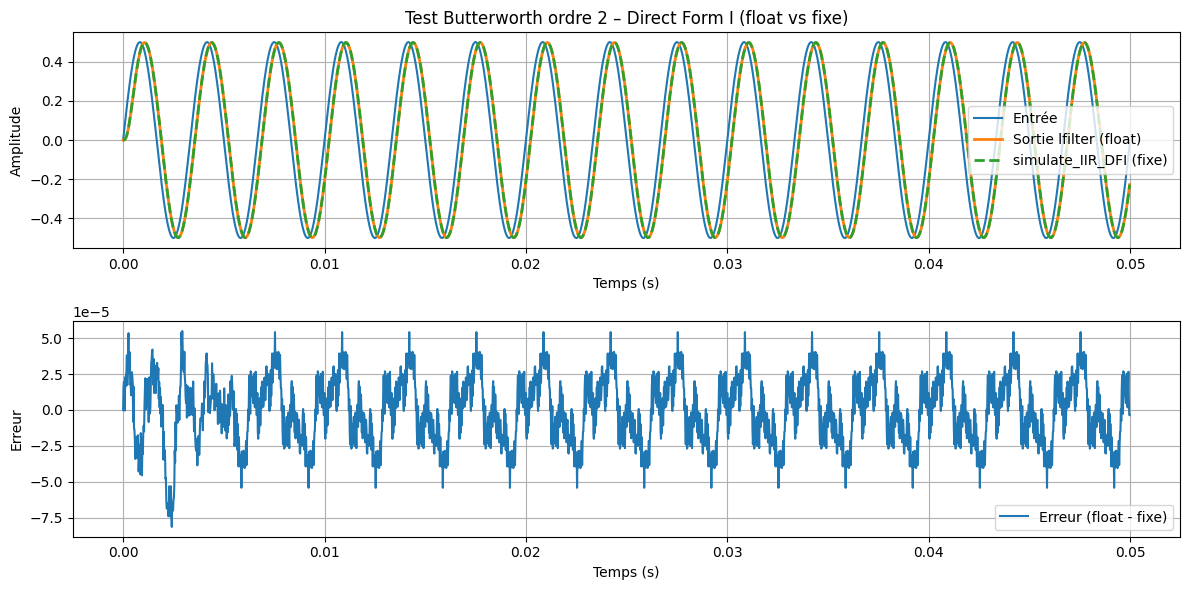

In [23]:
# Filtre de TEST simple (canonique)
fs_test = 48000        # fréquence d'échantillonnage
fc = 1000              # fréquence de coupure low-pass
N  = 2                 # ordre 2

b_lp, a_lp = butter(N, fc/(fs_test/2), btype='low', output='ba')

print("Coeffs Butterworth low-pass ordre 2 :")
print("b =", b_lp)
print("a =", a_lp)

# Signal de test : sinus DANS la bande
duration = 0.05  # 50 ms
t_lp = np.linspace(0, duration, int(fs_test*duration), endpoint=False)
u_lp = 0.5 * np.sin(2*np.pi*300*t_lp)  # 300 Hz, bien en dessous de fc=1000 Hz

# Paramètres de quantification
wl_in,  ib_in  = 16, 1   # Entrée : Q1.15
wl_b,   ib_b   = 20, 2   # Produits b : Q2.18 donc la ca ferais entre [-2, 1] avec scale=1/2^18
wl_a,   ib_a   = 20, 2   # Produits a : Q2.18
wl_ext, ib_ext = 28, 3   # Interne : Q3.25 (bits de garde)
wl_out, ib_out = 16, 1   # Sortie : Q1.15

# Simulation fixe vs flottant
y_lp_fix, y_lp_int = simulate_IIR_DFI(
    u_lp, b_lp, a_lp,
    wl_b, ib_b,
    wl_a, ib_a,
    wl_ext, ib_ext,
    wl_in, ib_in,
    wl_out, ib_out
)

y_lp_ref = lfilter(b_lp, a_lp, u_lp)

# Plots
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t_lp, u_lp, label="Entrée")
plt.plot(t_lp, y_lp_ref, label="Sortie lfilter (float)", linewidth=2)
plt.plot(t_lp, y_lp_fix, '--', label="simulate_IIR_DFI (fixe)", linewidth=2)
plt.title("Test Butterworth ordre 2 – Direct Form I (float vs fixe)")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_lp, y_lp_ref - y_lp_fix, label="Erreur (float - fixe)")
plt.xlabel("Temps (s)")
plt.ylabel("Erreur")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


# A-Weighting après la banc de filtres multirate ANSI 1/3-octave

Petit rappel ;')  
Le A-weighting (ou pondération A) est une courbe normalisée appliquée au signal audio pour modéliser la sensibilité réelle de l’oreille humaine en fonction de la fréquence

In [ ]:
class FIRFilter:
    """
    Réplique exacte du FIR Int32 utilisé dans le code Julia.
    - h : coefficients entiers du filtre FIR 
    - scaling : nombre de bits de shift à droite (division par 2^scaling)
    - state : registre à décalage interne
    """

    def __init__(self, h, scaling):
        self.h = np.array(h, dtype=np.int64) # int 64 pour éviter les débordements dans les calculs entiers
        self.scaling = scaling  # Nombre de bits pour le shift droit ce qui doit être équivalent à une division par 2^scaling pour ajuster l'échelle de sortie
        self.N = len(h)  # Longueur du filtre utile pour dimensionner le registre d'état
        self.state = np.zeros(self.N, dtype=np.int64)  # Shift register, initialisé à zéro il va donc stocker les échantillons passés

    def evaluate(self, x):
        """
        Filtrage FIR  :
        - on insère le nouvel échantillon en tête du registre
        - on décale tout le registre
        - on calcule la convolution state*h
        - on applique une division par 2^scaling via un shift logique
        """
        x = np.array(x, dtype=np.int64)  # Conversion de l'entrée en int64 pour les calculs entiers fixes
        y = np.zeros_like(x, dtype=np.int64)  # Tableau de sortie de même taille que l'entrée
        state = self.state.copy()  # Copie du registre d'état pour éviter de modifier l'état interne pendant le calcul

        for i, sample in enumerate(x): 
            state[1:] = state[:-1]  # Décalage du registre (poussé vers la droite)
            state[0] = sample 
            y[i] = np.sum(state * self.h) >> self.scaling  # Calcul de la convolution (produit scalaire) puis division par 2^scaling via shift droit

        self.state = state  # Mise à jour de l'état interne pour la prochaine évaluation (mémoire du filtre)
        return y


In [31]:
# Coefficients FIR F39 / F38 / F37 / D (issus de fir.jl)
F39_int = [-1,-6,14,-6,-22,43,-18,-41,66,-22,-36,35,1,19,-87,61,120,-274,149,
           208,-422,217,217,-422,208,149,-274,120,61,-87,19,1,35,-36,-22,66,
           -41,-18,43,-22,-6,14,-6,-1]
scale_F39 = 11

F38_int = [4,0,-13,3,26,-12,-38,26,41,-36,-33,33,13,-4,6,-56,-8,138,-21,-220,
           84,276,-167,-284,242,242,-284,-167,276,84,-220,-21,138,-8,-56,6,
           -4,13,33,-33,-36,41,26,-38,-12,26,3,-13,0,4]
scale_F38 = 11

F37_int = [-1,-3,2,7,2,-11,-11,9,22,3,-27,-21,20,36,-1,-37,-18,20,20,1,2,-4,
           -41,-30,66,100,-45,-174,-34,209,149,-172,-251,67,293,67,-251,
           -172,149,209,-34,-174,-45,100,66,-30,-41,-4,2,1,20,20,-18,-37,-1,
           36,20,-21,-27,3,22,9,-11,-11,2,7,2,-3,-1]
scale_F37 = 11

D_int = [0,21,31,-29,-77,45,171,-59,-375,69,1283,1975,1283,69,-375,-59,
         171,45,-77,-29,31,21,0]
scale_D = 12

In [ ]:
class FilterBank:
    """
    Implémentation équivalente à evaluate_filterbank() en Julia.
    On fait ici une implémentation du multirate ANSI :
    - À chaque octave : 3 FIR (F39, F38, F37)
    - Entre octaves : filtre anti-repliement D + décimation par 2
    """

    def __init__(self, F39, F38, F37, D, nb_octaves=6):
        self.F39 = F39
        self.F38 = F38
        self.F37 = F37
        self.D   = D
        self.nb_octaves = nb_octaves

    def downsample(self, x):
        """Décimation par 2 avec padding si nécessaire"""
        if len(x) % 2 == 1:  # Si la longueur est impaire alors on supprime le dernier échantillon pour éviter les erreurs de décimation
            x = x[:-1]
        return x[::2]  # Décimation par 2 : on garde un échantillon sur deux pour réduire la fréquence d'échantillonnage

    def evaluate(self, x):
        """
        Exécute le pipeline multirate complet
        Args:
            x : signal d'entrée (array de int64)
        Returns:
            outputs : liste de 18 signaux filtrés (par bande)
        """
        outputs = []

        # Octave 1 (pas de décimation encore)
        outputs.append(self.F39.evaluate(x))
        outputs.append(self.F38.evaluate(x))
        outputs.append(self.F37.evaluate(x))

        d = self.D.evaluate(x)  # Application du filtre anti-repliement D avant décimation pour éviter les aliasing

        # Octaves suivantes : décimation + filtrage pour chaque octave
        for _ in range(2, self.nb_octaves):  
            d = self.downsample(d)  

            outputs.append(self.F39.evaluate(d))
            outputs.append(self.F38.evaluate(d))
            outputs.append(self.F37.evaluate(d))

            d = self.D.evaluate(d)

        # Dernière décimation + dernière octave
        d = self.downsample(d)
        outputs.append(self.F39.evaluate(d))
        outputs.append(self.F38.evaluate(d))
        outputs.append(self.F37.evaluate(d))

        return outputs


In [33]:
fb = FilterBank(
    FIRFilter(F39_int, scale_F39),
    FIRFilter(F38_int, scale_F38),
    FIRFilter(F37_int, scale_F37),
    FIRFilter(D_int,   scale_D),
    nb_octaves=6
)


In [ ]:
def compute_y_square_sum(outputs, nb_octaves=6):
    """
    Calcule les énergies quadratiques pour chaque bande et chaque tranche de temps

    Args:
        outputs (liste) : liste de 18 signaux filtrés (F39, F38, F37 pour chaque octave)
        nb_octaves (entier, facultatif) : nombre d'octaves. La valeur par défaut est 6

    Returns:
        np.ndarray : tableau 2D de forme (18, N) où N est le nombre de segments qui contient les énergies quadratiques moyennes par bande et par segment
    """
    

    



    chunk = 2**(nb_octaves - 1)  # Taille initiale des chunks pour l'octave la plus haute (fs / 2^(nb_octaves-1))
    result = []  # Liste pour collecter les tableaux d'énergies pour chaque bande

    idx = 0
    for octave in range(nb_octaves): 
        for _ in range(3):  # Pour chaque bande dans l'octave (F39, F38, F37)
            y = outputs[idx]  # On récupère le signal filtré pour cette bande
            idx += 1 

            n_chunks = len(y) // chunk  # Nombre de chunks dans ce signal (longueur divisée par taille du chunk)
            energies = []  # Liste pour les énergies de cette bande

            for k in range(n_chunks):
                seg = y[k*chunk:(k+1)*chunk]  # On extrait le segment du signal
                energies.append(np.mean(seg.astype(float)**2))  # on calcule l'énergie moyenne (moyenne des carrés) du segment

            result.append(energies)

        chunk //= 2  # On divise la taille du chunk par 2 pour l'octave suivante (car on a la décimation par 2)

    return np.array(result)


In [35]:
fs, x = wavfile.read("test.wav")

# Convertir en mono si stéréo
if x.ndim > 1:
    x = np.mean(x, axis=1)

x = x.astype(np.int64)

outputs = fb.evaluate(x)
energies = compute_y_square_sum(outputs)

np.savetxt("y_square_sum.txt", energies)

/tmp/ipykernel_136962/2700239893.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = wavfile.read("test.wav")


Fréquences des bandes (Hz) : [100, 125, 160, 200, 250, 320, 400, 500, 640, 800, 1000, 1280, 1600, 2000, 2560, 3200, 4000, 5120, 6400, 8000, 10240]
Fréquences des bandes utilisées (Hz) : [160, 200, 250, 320, 400, 500, 640, 800, 1000, 1280, 1600, 2000, 2560, 3200, 4000, 5120, 6400, 8000]


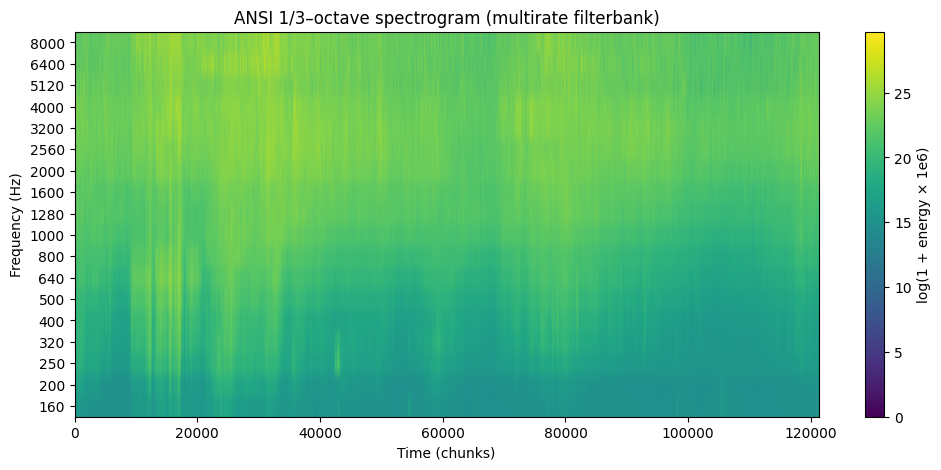

In [37]:
def plot_ansi_spectrogram(energies):

    # fréquences centrales des bandes 1/3 octave selon le standard ANSI S1.11
    freq_labels = [100,125,160]
    for _ in range(1,7):
        freq_labels += list((np.array(freq_labels[-3:])*2).astype(int))
    
    print("Fréquences des bandes (Hz) :", freq_labels)
    freq_labels = freq_labels[2:-1]  # même indexation que le Julia
    print("Fréquences des bandes utilisées (Hz) :", freq_labels)

    plt.figure(figsize=(12,5))
    plt.imshow(np.log1p(1e6*np.abs(energies)), 
               aspect="auto", origin="lower")
    plt.colorbar(label="log(1 + energy × 1e6)")
    plt.yticks(np.arange(18), freq_labels)
    plt.xlabel("Time (chunks)")
    plt.ylabel("Frequency (Hz)")
    plt.title("ANSI 1/3–octave spectrogram (multirate filterbank)")
    plt.show()

plot_ansi_spectrogram(energies)
